In [1]:
#########################################################################################################################
# Kurs: Zarządzanie informacją w organizacji, studia zaoczne, Informatyka w Biznesie
# Data ostatniej poprawki: 15.01.2018
# Autorzy: Mariusz Czarny, Marta Oleszczyk, Marcin Szadkowski

# Celem projektu jest zastosowanie języka Python przy użyciu bibliotek pandas, nympy, itp., aby wykonać analizę danych.
# Dane źródłowe stanowią pliki tekstowe: campaigns.txt, customers.txt, orderlines.txt, orders.txt, products.txt pobrane z
# serwera: https://drive.google.com/drive/folders/0B1A_5ELLOtW4VXgwOG1oZmhpS0k
# Ścieżka źródłowa dla plików: powinny znajdować się w tym samym katalogu co plik projektowy
# Wersja pythona: 3.6.3
# Plik dostępny jest także pod linkiem: https://github.com/MariuszWroc/dataScience

# User story: W pierwszej części projektu program tworzy wewnętrzną bazę danych na podstawie plików tekstowych z danymi 
# finansowymi. Wybrano do analizy danych kilka przypadków użycia:
# + sprawdzenie jaki jest stosunek liczby kobiet do mężczyzn wśród wszystkich klientów
# + pokazanie jaki jest stosunek poszczególnych kategorii produktów
# + zobaczenie jak sprzedawały się produkty, które są grami, i zostały kupione w 2016 roku w stanie Nowy York
# + sprawdzenie, które karty płątnicze są najczęściej używane przez kilentów stanie Delaware (DE)
# + sprawdzenie jak jest łączna kwota wydana w poszczególnych stanach
# + sprawdzenie kwoty wydatków dla każdej płci w stanach z zanotowaną najwyższą kwotą sprzedaży
#########################################################################################################################

In [2]:
# import wewenątrznej bazy danych
import sqlite3

In [3]:
# import standardowych bibliotek
import pandas as pd
import numpy as np
import os

In [4]:
# import bibliotek służących do wizualizacji
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [5]:
# sprawdza aktualną ścieżkę
%pwd

'C:\\Users\\czarnym\\Documents\\Development\\studia\\jupiter\\dataScience'

In [6]:
# połączenie z bazą i wykorzystanie kursora
dbConnection = sqlite3.connect("bookdb");
dbCursor = dbConnection.cursor()

In [7]:
# rozszerzenie plików zawierających dane do wczytania
txtExtention = ".txt"

In [8]:
# tablica z nazwami plików do oczytu, zawierające dane, które będą importowane do tabel bazodanowych
tables = ["Customers", "Orderlines", "Products", "Campaigns", "Orders"]

In [9]:
# wczytywanie kolejnych plików w pętli for
for table in tables:
    # ustawienie sciezki (nazwy plikow pisane malymy literami)
    path = os.path.expanduser(table.lower() + txtExtention)
    # wczytywanie pliku używając delimitera tabulacji oraz kodowania 'latin1'
    file = pd.read_csv(path, delimiter="\t", encoding = 'latin1')
    # tworzy na podstawie pliku tabele i wypełnia ją rekordami, jesli instnieje zostaje nadpisana
    file.to_sql(table, dbConnection, if_exists="replace");

In [10]:
# pobranie informacji do DataFrame
selectGenderQuery = '''SELECT o.orderdate, c.gender, c.firstname from Orders o join Customers c on o.customerid = c.customerid '''
genderDF = pd.read_sql_query(selectGenderQuery, dbConnection)

In [11]:
# sprawdzanie czy rekordy się wczytały
genderDF.head()

,orderdate,gender,firstname
0,2009-10-13 00:00:00,M,LOUIS
1,2009-10-13 00:00:00,M,ANTHONY
2,2011-06-02 00:00:00,None,MERRILL
3,2009-10-14 00:00:00,F,MARIA
4,2010-11-19 00:00:00,None,T.


In [12]:
# usunięcie niepotrzebnych wartosci z daty do roku i konwersja typu na typ całkowity
genderDF["orderdate"] = genderDF["orderdate"].str[:-15].astype(np.int64)

In [13]:
# ustawienie wyników na daty większe niż 2015 rok 
genderDF = genderDF[genderDF["orderdate"] >= 2015]

In [14]:
# zmiana nazwy kolumny
genderDF.rename(columns={'orderdate': 'year'}, inplace=True)
# reindeksacja według kolumny 'year'
genderDF = genderDF.set_index("year")
# usunięcie pustych krotek
genderDF = genderDF.dropna()
# posortowanie rekordów po indexie
genderDF.sort_index()

,gender,firstname
year,,
2015,M,PAUL
2015,M,STEVEN
2015,M,EDWARD
2015,M,ALLEN
2015,M,GREGORY
2015,F,LINDA
2015,F,WILMA
2015,F,SUZANNE
2015,M,RICHARD


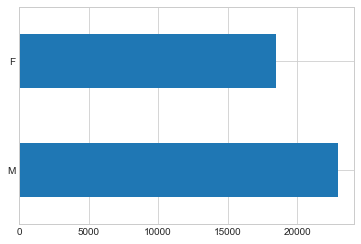

In [15]:
# policzenie liczby kobiet i mężczyzn w DataFrame
genderCounts = pd.value_counts(genderDF['gender'].values, sort=False)
# rysowanie wykresu
genderCounts[:].plot(kind='barh', rot=0)

In [16]:
# wczytanie informacji o grupach produktów
selectProductGroupsQuery = '''select p.PRODUCTGROUPNAME, p.INSTOCKFLAG, ol.unitprice from Products p 
                              join Orderlines ol on p.productid = ol.productid'''
groupsDF = pd.read_sql_query(selectProductGroupsQuery, dbConnection)
groupsDF = groupsDF.dropna()
# eliminacja rekordów które w kolumnie 'PRODUCTGROUPNAME' są ustawione na 'FREEBIE'
groupsDF = groupsDF[groupsDF["PRODUCTGROUPNAME"] != "FREEBIE"]
# czy jest w magazynie
groupsDF = groupsDF[groupsDF["INSTOCKFLAG"] == 'Y']  
# czy eliminacja wartości  jednostkowej równej zero
groupsDF = groupsDF[groupsDF["unitprice"] > 0]       
# sortowanie
groupsDF.sort_values("unitprice", ascending=False)

,PRODUCTGROUPNAME,INSTOCKFLAG,unitprice
160805,ARTWORK,Y,6250.00
160804,ARTWORK,Y,6250.00
160803,ARTWORK,Y,5967.37
160763,ARTWORK,Y,3165.00
160764,ARTWORK,Y,3165.00
160811,ARTWORK,Y,3145.00
160762,ARTWORK,Y,3127.00
160769,ARTWORK,Y,3000.00
160756,ARTWORK,Y,3000.00
160755,ARTWORK,Y,3000.00


In [17]:
# policzenie średniej dla typoów produktów
groupsDF = groupsDF.groupby(["PRODUCTGROUPNAME"]).mean()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B138058A58>], dtype=object)

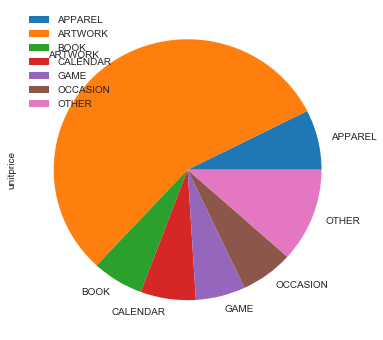

In [18]:
# rysowanie wykresu
groupsDF.plot(kind='pie', legend=True, subplots=True, figsize=(6, 6))

In [19]:
# wczytywanie informacji o produktach powiązanych z zamówieniami i linią zamówieniową
productQuery = '''
SELECT ol.billdate, ol.totalprice, o.city, p.PRODUCTGROUPNAME
FROM Orders o JOIN Orderlines ol ON o.orderid = ol.orderid 
JOIN Products p ON ol.productid = p.PRODUCTID
'''

In [20]:
gamesDF = pd.read_sql_query(productQuery, dbConnection)
gamesDF.head()

,billdate,totalprice,city,PRODUCTGROUPNAME
0,2009-11-12 00:00:00,175.00,NEWTON,ARTWORK
1,2009-11-26 00:00:00,10.00,NEWTON,ARTWORK
2,2009-10-23 00:00:00,5.00,NEWTON,OCCASION
3,2009-11-04 00:00:00,10.00,NEW ROCHELLE,ARTWORK
4,2011-06-06 00:00:00,17.61,MIAMI,OCCASION


In [21]:
# konwersja daty na rok (jako liczba całkowita)
gamesDF["year"] = gamesDF["billdate"].str[:-15].astype(np.int64)
gamesDF["billdate"] = gamesDF["billdate"].str[:-9]
# usunięcie zer z daty i zapisanie ją jako typ datowy
gamesDF["billdate"] = pd.to_datetime(gamesDF["billdate"])
# sprawdzenie typu dla pewności czy konwersja zaszła poprawnie
gamesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286017 entries, 0 to 286016
Data columns (total 5 columns):
billdate            286017 non-null datetime64[ns]
totalprice          286017 non-null float64
city                285983 non-null object
PRODUCTGROUPNAME    286008 non-null object
year                286017 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 10.9+ MB


In [22]:
# filtrowanie danych, wyszukiwanie produktów które są grami, i sprzedały się w 2016 roku w stanie Nowy York
gamesDF = gamesDF[gamesDF["year"] == 2016]
gamesDF = gamesDF[gamesDF["city"] == "NEW YORK"]
gamesDF = gamesDF[gamesDF["PRODUCTGROUPNAME"] == "GAME"]
gamesDF = gamesDF.set_index("billdate")
gamesDF.head()

,totalprice,city,PRODUCTGROUPNAME,year
billdate,,,,
2016-01-05,7.44,NEW YORK,GAME,2016
2016-01-07,13.49,NEW YORK,GAME,2016
2016-01-15,44.95,NEW YORK,GAME,2016
2016-01-25,44.95,NEW YORK,GAME,2016
2016-02-01,44.95,NEW YORK,GAME,2016


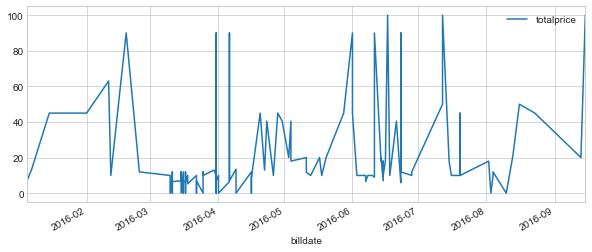

In [23]:
# rysowanie wykresu
gamesDF['totalprice'].plot(legend=True,figsize=(10,4))

In [24]:
# Tablica z zakresami wyrażona w dniach
movingAvarages = [7,30,60,90]

# Obliczanie średniej ruchomej
for avarage in movingAvarages:
    column_name = "MA for %s days" %(str(avarage))
    gamesDF[column_name]=gamesDF['totalprice'].rolling(window=avarage).mean()

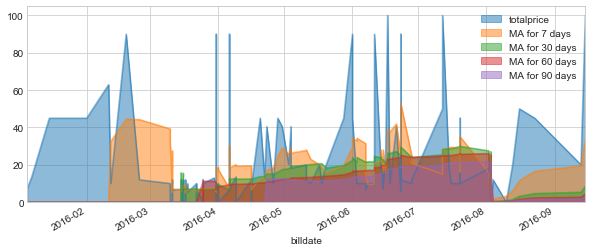

In [25]:
# rysowanie wykresu
gamesDF[['totalprice','MA for 7 days','MA for 30 days','MA for 60 days','MA for 90 days']].plot(kind='area', stacked=False, subplots=False,figsize=(10,4))

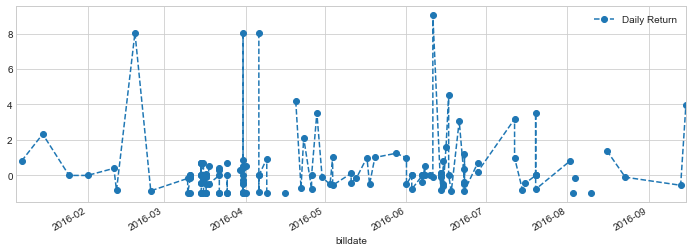

In [26]:
# pct_change - wyszukuje procentową zmianę dla każdego dnia
gamesDF['Daily Return'] = gamesDF['totalprice'].pct_change()
# Procentowy dzienny zwrot - wykres
gamesDF['Daily Return'].plot(figsize=(12,4),legend=True,linestyle='--',marker='o')

In [27]:
# pobranie danych o typie płatności 
paymenttypeDF = pd.read_sql_query('''select paymenttype,state, totalprice, customerid from Orders
where state="DE"''', dbConnection)

In [28]:
# Sprawdzamy, które karty są najczęściej używane przez kilentów stanie DE 

In [29]:
paymenttypeCounts=pd.value_counts(paymenttypeDF["paymenttype"].values)
paymenttypeCounts[:5]

VI    331
MC    141
AE     87
DB     44
OC     37
dtype: int64

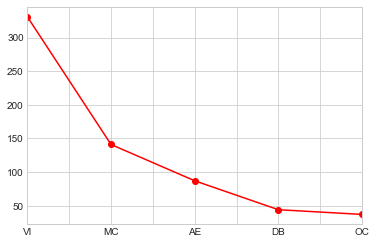

In [30]:
paymenttypeCounts[:5].plot(marker="o", color ="r")

In [31]:
# pobranie informacji o stanach dla poszczególnych zamówień
stateDF = pd.read_sql_query('''select state, totalprice from Orders''', dbConnection)

In [32]:
expenses= pd.read_sql_query('''SELECT o.state, c.gender, o.totalprice  from Orders o join Customers c on o.customerid = c.customerid 
                    ''', dbConnection)

In [33]:
# Sprawdzamy łączną kwotę wydaną w poszczególnych stanch 

In [34]:
statesExpenses=pd.value_counts(stateDF['state'].values)
statesExpenses[:10]

NY    53537
NJ    21274
CA    17839
FL    10185
CT     9369
PA     7079
MA     6942
TX     6247
IL     5812
VA     4174
dtype: int64

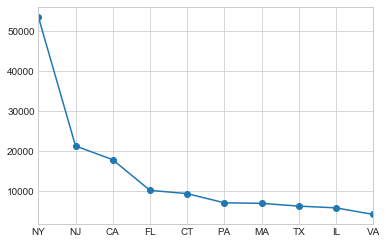

In [35]:
statesExpenses[:10].plot(marker ='o')

In [36]:
genderStateDF = pd.read_sql_query('''select state, gender, totalprice from Orders o join Customers c on o.customerid=c.customerid''', dbConnection)

In [38]:
# Sprawdzamy kwotę wydatków dla każdej płc w stanach
# z zanotowaną najwyższą kwotą sprzedaży
genderExpenses=np.where(genderStateDF['gender']=='M', 'Man','Woman')
genderExpensesTab=expenses.groupby(['state', genderExpenses])
genderExpensesTabSize = genderExpensesTab.size().unstack().fillna(0)

In [39]:
# Sortowanie po wartościach dla kobiet zaczynając od najmniejszych wartość
genderExpensesDF=genderExpensesTabSize.sort_values("Woman", ascending=False)

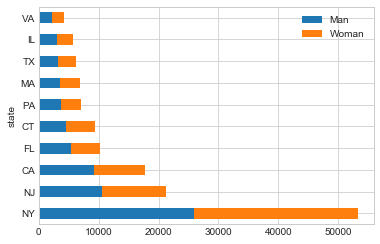

In [40]:
# rysujemy wykres
genderExpensesDF=genderExpensesDF[:10].plot(kind='barh', stacked=True)
